In [1]:
%env OMP_NUM_THREADS=1
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt
from scattering import *
from mesh import *

env: OMP_NUM_THREADS=1


In [2]:
c = 340
x0 = fd.Constant([0.5, 0])
N = 2

In [3]:
def exact_solution(mesh, k, x0):
    x = fd.SpatialCoordinate(mesh)
    z = k * fd.sqrt(fd.inner(x - x0, x - x0))
    u_re = -fd.bessel_Y(0, z) / 4
    u_im = fd.bessel_J(0, z) / 4
    return fd.as_vector([u_re, u_im])

def neumann_bc(mesh, k, x0):
    x = fd.SpatialCoordinate(mesh)
    n = fd.FacetNormal(mesh)
    z = k * fd.sqrt(fd.inner(x - x0, x - x0))
    dzdn = k / fd.sqrt(fd.inner(x - x0, x - x0)) * fd.dot(x - x0, n)
    dudn_re = fd.bessel_Y(1, z) / 4 * dzdn
    dudn_im = -fd.bessel_J(1, z) / 4 * dzdn
    return fd.as_vector([dudn_re, dudn_im])

# Sphere

In [4]:
shape = "sphere"
a0 = b0 = 2.0
a1 = b1 = 2.25
h0 = (a1 - a0) / N
cached_mesh = True

if cached_mesh:
    mesh = fd.Mesh(shape + str(0) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, N)

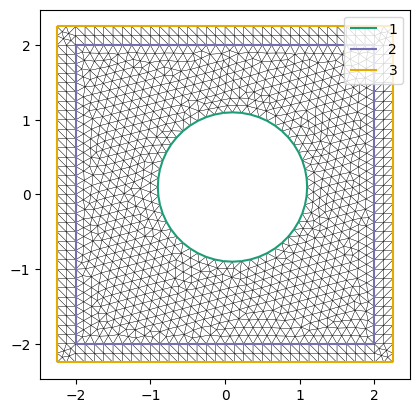

In [5]:
plot_mesh(mesh)

In [6]:
omega = 250
k = omega / c
u = exact_solution(mesh, k, x0)
uh = solve(mesh, k, a0, a1, b0, b1, u)

Exact solution:


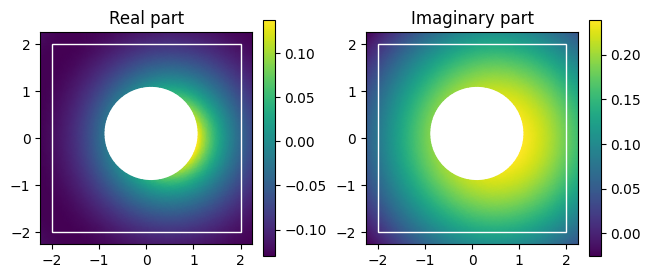

In [7]:
print("Exact solution:")
W = fd.VectorFunctionSpace(mesh, "CG", 1)
plot_field(fd.interpolate(u, W), a0, a1, b0, b1)

Numerical solution:


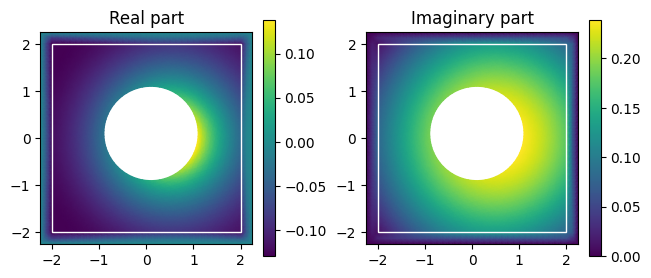

In [8]:
print("Numerical solution:")
plot_field(uh, a0, a1, b0, b1)

In [9]:
rel_err = compute_error(u, uh, quad_deg=4)
print(f"Relative error {rel_err:.2%}")

Relative error 1.20%


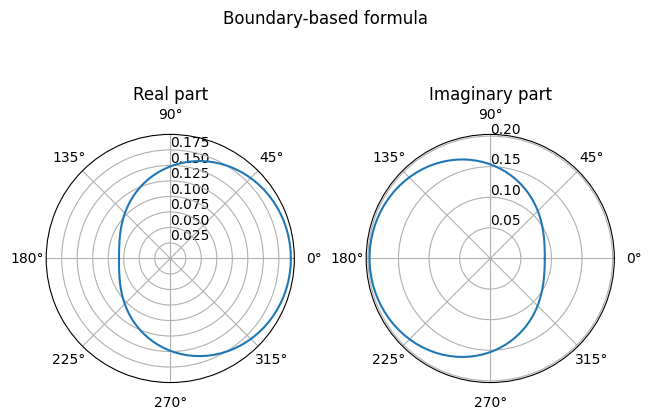

In [10]:
plot_far_field(k, uh)

In [11]:
# Convergence
max_level = 4
levels = np.arange(max_level)
hs = h0 / 2**levels
omegas = [250, 750, 1250]

In [12]:
mesh_hierarchy = []
if cached_mesh:
    for level in levels:
        mesh_hierarchy.append(fd.Mesh(shape + str(level) + ".msh"))
else:
    for level in levels:
        mesh_hierarchy.append(generate_mesh(a0, a1, b0, b1, shape, N, level))

angular freqency = 250
refinement level 0, relative error 1.20%
refinement level 1, relative error 0.26%
refinement level 2, relative error 0.08%
refinement level 3, relative error 0.02%
convergence rate = 2.0
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.02%
refinement level 1, relative error 0.65%
refinement level 2, relative error 0.19%
refinement level 3, relative error 0.06%
convergence rate = 1.7
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.14%
refinement level 1, relative error 0.83%
refinement level 2, relative error 0.25%
refinement level 3, relative error 0.07%
convergence rate = 1.8
----------------------------------------


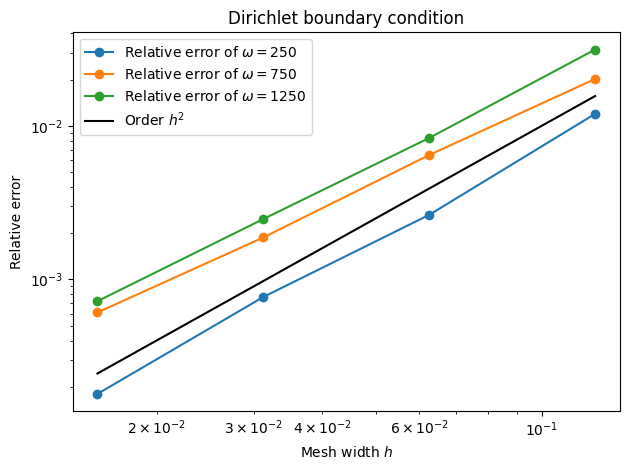

In [13]:
# Dirichlet problem
# L2 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    k = np.polyfit(np.log(hs), np.log(errors), 1)[0]
    print(f"convergence rate = {k:.2}")
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.88%
refinement level 1, relative error 1.27%
refinement level 2, relative error 0.62%
refinement level 3, relative error 0.31%
convergence rate = 1.1
----------------------------------------
angular freqency = 750
refinement level 0, relative error 6.88%
refinement level 1, relative error 3.34%
refinement level 2, relative error 1.64%
refinement level 3, relative error 0.82%
convergence rate = 1.0
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 11.47%
refinement level 1, relative error 5.59%
refinement level 2, relative error 2.77%
refinement level 3, relative error 1.38%
convergence rate = 1.0
----------------------------------------


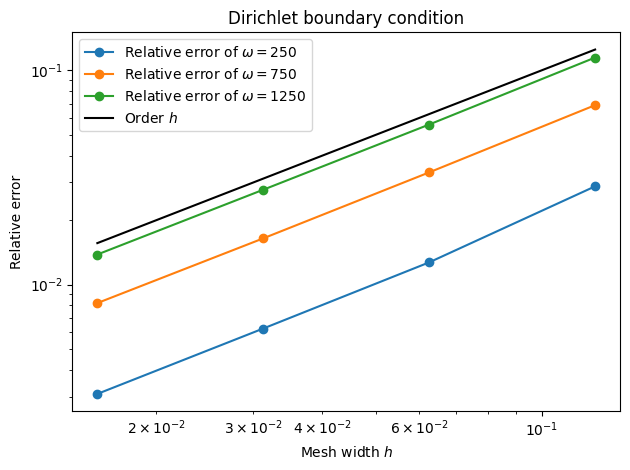

In [14]:
# Dirichlet problem
# H1 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, norm="h1", quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    k = np.polyfit(np.log(hs), np.log(errors), 1)[0]
    print(f"convergence rate = {k:.2}")
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.23%
refinement level 1, relative error 0.46%
refinement level 2, relative error 0.10%
refinement level 3, relative error 0.03%
convergence rate = 2.1
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.27%
refinement level 1, relative error 0.74%
refinement level 2, relative error 0.22%
refinement level 3, relative error 0.06%
convergence rate = 1.7
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.10%
refinement level 1, relative error 0.85%
refinement level 2, relative error 0.26%
refinement level 3, relative error 0.08%
convergence rate = 1.8
----------------------------------------


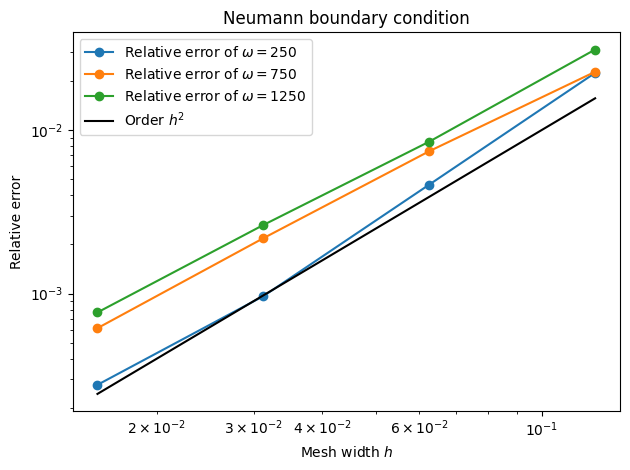

In [15]:
# Neumann problem
# L2 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    k = np.polyfit(np.log(hs), np.log(errors), 1)[0]
    print(f"convergence rate = {k:.2}")
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 3.15%
refinement level 1, relative error 1.30%
refinement level 2, relative error 0.63%
refinement level 3, relative error 0.31%
convergence rate = 1.1
----------------------------------------
angular freqency = 750
refinement level 0, relative error 7.03%
refinement level 1, relative error 3.38%
refinement level 2, relative error 1.65%
refinement level 3, relative error 0.82%
convergence rate = 1.0
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 11.45%
refinement level 1, relative error 5.59%
refinement level 2, relative error 2.77%
refinement level 3, relative error 1.38%
convergence rate = 1.0
----------------------------------------


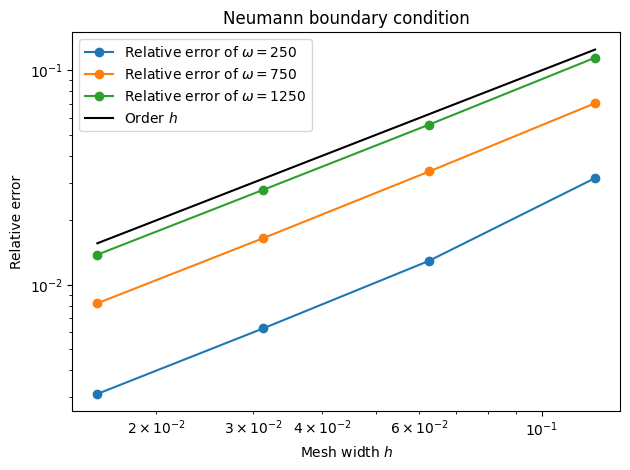

In [16]:
# Neumann problem
# H1 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, norm="h1", quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    k = np.polyfit(np.log(hs), np.log(errors), 1)[0]
    print(f"convergence rate = {k:.2}")
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

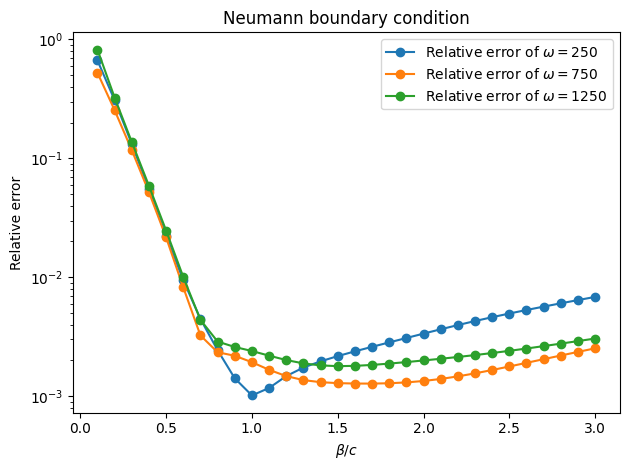

In [17]:
neumann = True
m = mesh_hierarchy[2]
betas = np.linspace(0.1, 3, 30)
for omega in omegas:
    # print(f"angular freqency = {omega}")
    k = omega / c
    g = neumann_bc(m, k, x0)
    u = exact_solution(m, k, x0)
    errors = []
    for beta in betas:
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, beta=beta)
        rel_err = compute_error(u, uh)
        # print(f"beta {beta:.2}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.semilogy(betas, errors, "-o",
             label=r"Relative error of $\omega=$"+f"{omega}")
    # print("----------------------------------------")

plt.legend()
plt.xlabel(r"$\beta / c$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

# Kite

In [18]:
shape = "kite"
a0 = b0 = 2.0
a1 = b1 = 2.25
h0 = (a1 - a0) / N
cached_mesh = True

if cached_mesh:
    mesh = fd.Mesh(shape + str(0) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, N)

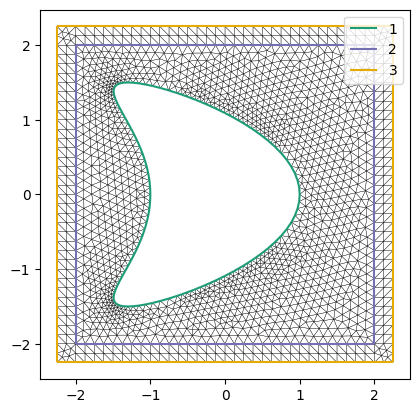

In [19]:
plot_mesh(mesh)

In [20]:
omega = 250
k = omega / c
u = exact_solution(mesh, k, x0)
uh = solve(mesh, k, a0, a1, b0, b1, u)

Exact solution:


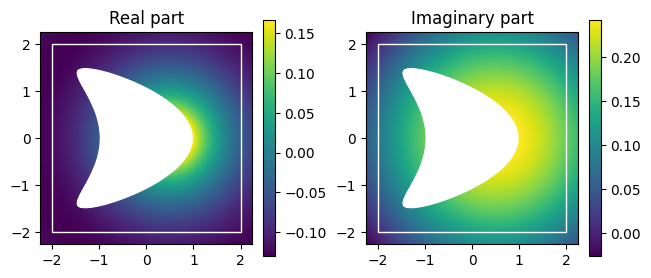

In [21]:
print("Exact solution:")
W = fd.VectorFunctionSpace(mesh, "CG", 1)
plot_field(fd.interpolate(u, W), a0, a1, b0, b1)

Numerical solution:


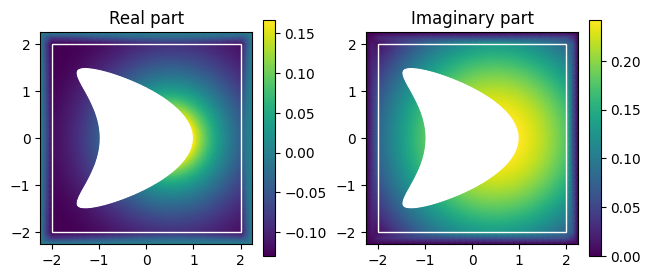

In [22]:
print("Numerical solution:")
plot_field(uh, a0, a1, b0, b1)

In [23]:
rel_err = compute_error(u, uh, quad_deg=4)
print(f"Relative error {rel_err:.2%}")

Relative error 1.29%


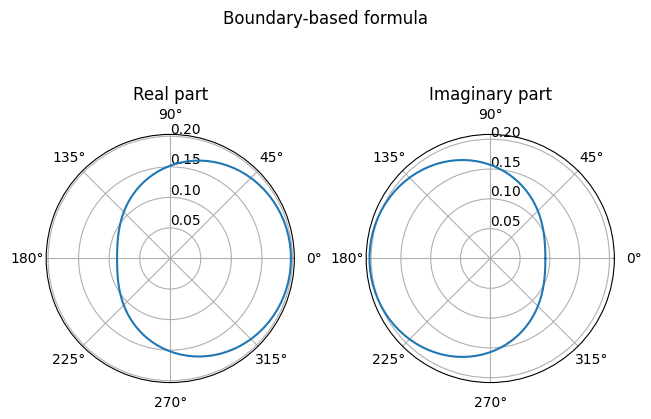

In [24]:
plot_far_field(k, uh)

In [25]:
# Convergence
max_level = 4
levels = np.arange(max_level)
hs = h0 / 2**levels
omegas = [250, 750, 1250]

In [26]:
mesh_hierarchy = []
if cached_mesh:
    for level in levels:
        mesh_hierarchy.append(fd.Mesh(shape + str(level) + ".msh"))
else:
    for level in levels:
        mesh_hierarchy.append(generate_mesh(a0, a1, b0, b1, shape, N, level))

angular freqency = 250
refinement level 0, relative error 1.29%
refinement level 1, relative error 0.27%
refinement level 2, relative error 0.08%
refinement level 3, relative error 0.02%
convergence rate = 2.0
----------------------------------------
angular freqency = 750
refinement level 0, relative error 1.86%
refinement level 1, relative error 0.60%
refinement level 2, relative error 0.17%
refinement level 3, relative error 0.06%
convergence rate = 1.7
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 2.71%
refinement level 1, relative error 0.74%
refinement level 2, relative error 0.23%
refinement level 3, relative error 0.07%
convergence rate = 1.7
----------------------------------------


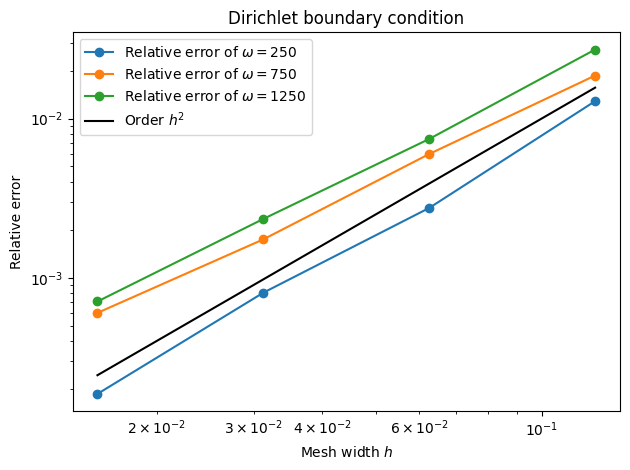

In [27]:
# Dirichlet problem
# L2 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    k = np.polyfit(np.log(hs), np.log(errors), 1)[0]
    print(f"convergence rate = {k:.2}")
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.81%
refinement level 1, relative error 0.99%
refinement level 2, relative error 0.40%
refinement level 3, relative error 0.18%
convergence rate = 1.3
----------------------------------------
angular freqency = 750
refinement level 0, relative error 6.09%
refinement level 1, relative error 2.60%
refinement level 2, relative error 1.12%
refinement level 3, relative error 0.53%
convergence rate = 1.2
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 9.87%
refinement level 1, relative error 4.31%
refinement level 2, relative error 1.90%
refinement level 3, relative error 0.89%
convergence rate = 1.2
----------------------------------------


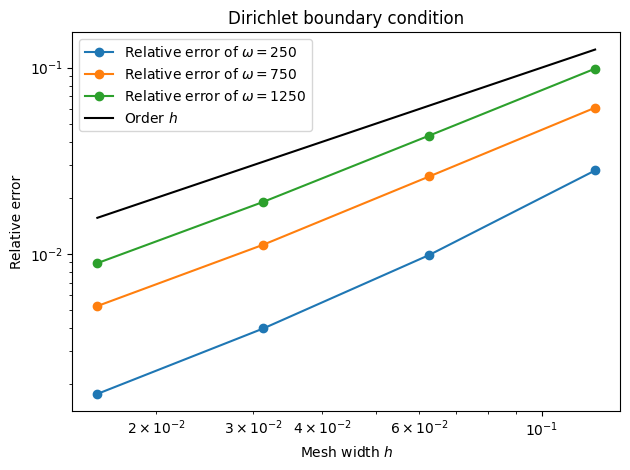

In [28]:
# Dirichlet problem
# H1 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, norm="h1", quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    k = np.polyfit(np.log(hs), np.log(errors), 1)[0]
    print(f"convergence rate = {k:.2}")
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.39%
refinement level 1, relative error 0.49%
refinement level 2, relative error 0.10%
refinement level 3, relative error 0.03%
convergence rate = 2.1
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.65%
refinement level 1, relative error 0.90%
refinement level 2, relative error 0.26%
refinement level 3, relative error 0.07%
convergence rate = 1.7
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 2.82%
refinement level 1, relative error 0.82%
refinement level 2, relative error 0.28%
refinement level 3, relative error 0.08%
convergence rate = 1.7
----------------------------------------


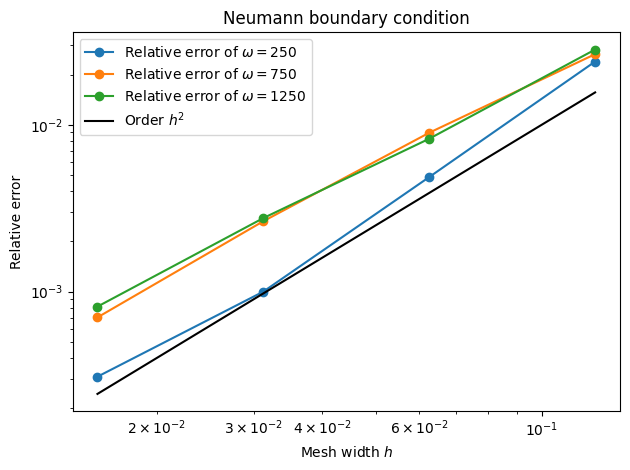

In [29]:
# Neumann problem
# L2 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    k = np.polyfit(np.log(hs), np.log(errors), 1)[0]
    print(f"convergence rate = {k:.2}")
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 3.10%
refinement level 1, relative error 1.02%
refinement level 2, relative error 0.40%
refinement level 3, relative error 0.18%
convergence rate = 1.4
----------------------------------------
angular freqency = 750
refinement level 0, relative error 6.36%
refinement level 1, relative error 2.68%
refinement level 2, relative error 1.14%
refinement level 3, relative error 0.53%
convergence rate = 1.2
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 9.92%
refinement level 1, relative error 4.33%
refinement level 2, relative error 1.91%
refinement level 3, relative error 0.89%
convergence rate = 1.2
----------------------------------------


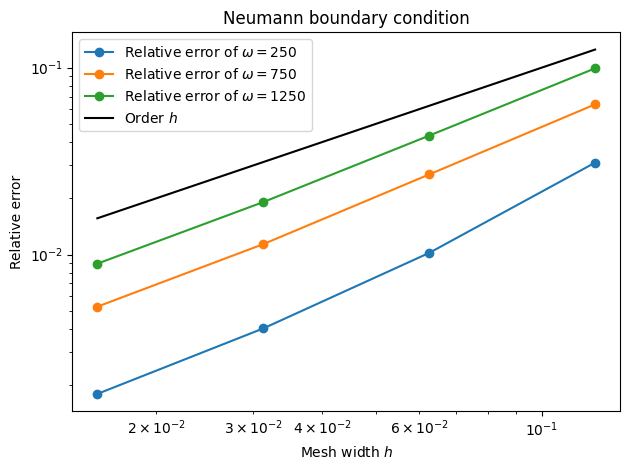

In [30]:
# Neumann problem
# H1 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, norm="h1", quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    k = np.polyfit(np.log(hs), np.log(errors), 1)[0]
    print(f"convergence rate = {k:.2}")
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

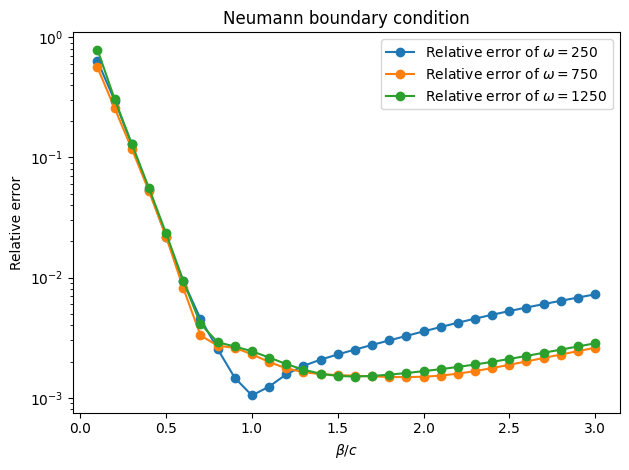

In [31]:
neumann = True
m = mesh_hierarchy[2]
betas = np.linspace(0.1, 3, 30)
for omega in omegas:
    # print(f"angular freqency = {omega}")
    k = omega / c
    g = neumann_bc(m, k, x0)
    u = exact_solution(m, k, x0)
    errors = []
    for beta in betas:
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, beta=beta)
        rel_err = compute_error(u, uh)
        # print(f"beta {beta:.2}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.semilogy(betas, errors, "-o",
             label=r"Relative error of $\omega=$"+f"{omega}")
    # print("----------------------------------------")

plt.legend()
plt.xlabel(r"$\beta / c$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

# Square

In [32]:
shape = "square"
a0 = b0 = 2.0
a1 = b1 = 2.25
h0 = (a1 - a0) / N
cached_mesh = True

if cached_mesh:
    mesh = fd.Mesh(shape + str(0) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, N)

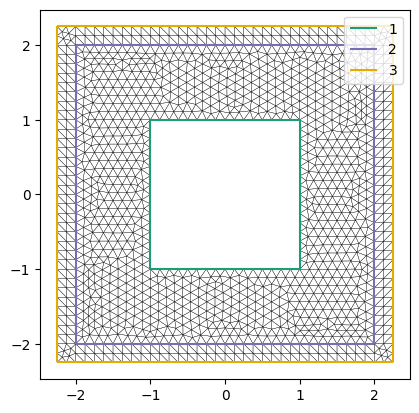

In [33]:
plot_mesh(mesh)

In [34]:
omega = 250
k = omega / c
u = exact_solution(mesh, k, x0)
uh = solve(mesh, k, a0, a1, b0, b1, u)

Exact solution:


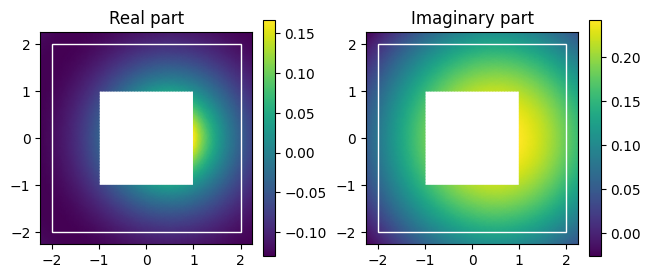

In [35]:
print("Exact solution:")
W = fd.VectorFunctionSpace(mesh, "CG", 1)
plot_field(fd.interpolate(u, W), a0, a1, b0, b1)

Numerical solution:


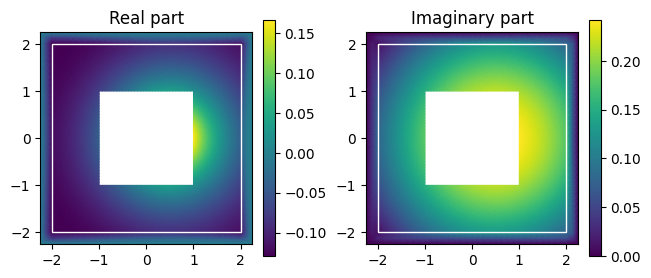

In [36]:
print("Numerical solution:")
plot_field(uh, a0, a1, b0, b1)

In [37]:
rel_err = compute_error(u, uh, quad_deg=4)
print(f"Relative error {rel_err:.2%}")

Relative error 1.08%


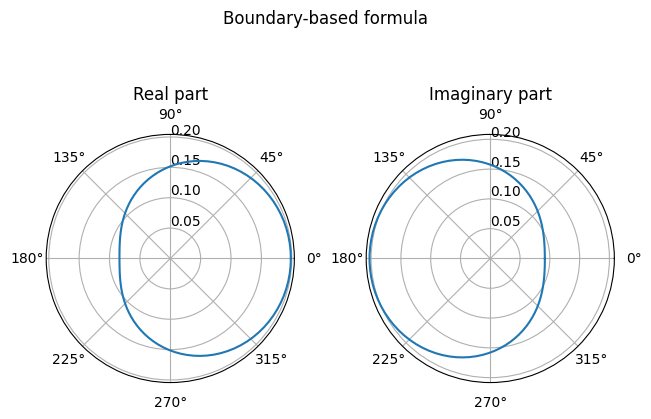

In [38]:
plot_far_field(k, uh)

In [39]:
# Convergence
max_level = 4
levels = np.arange(max_level)
hs = h0 / 2**levels
omegas = [250, 750, 1250]

In [40]:
mesh_hierarchy = []
if cached_mesh:
    for level in levels:
        mesh_hierarchy.append(fd.Mesh(shape + str(level) + ".msh"))
else:
    for level in levels:
        mesh_hierarchy.append(generate_mesh(a0, a1, b0, b1, shape, N, level))

angular freqency = 250
refinement level 0, relative error 1.08%
refinement level 1, relative error 0.24%
refinement level 2, relative error 0.07%
refinement level 3, relative error 0.02%
convergence rate = 1.9
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.09%
refinement level 1, relative error 0.67%
refinement level 2, relative error 0.19%
refinement level 3, relative error 0.06%
convergence rate = 1.7
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.33%
refinement level 1, relative error 0.90%
refinement level 2, relative error 0.27%
refinement level 3, relative error 0.08%
convergence rate = 1.8
----------------------------------------


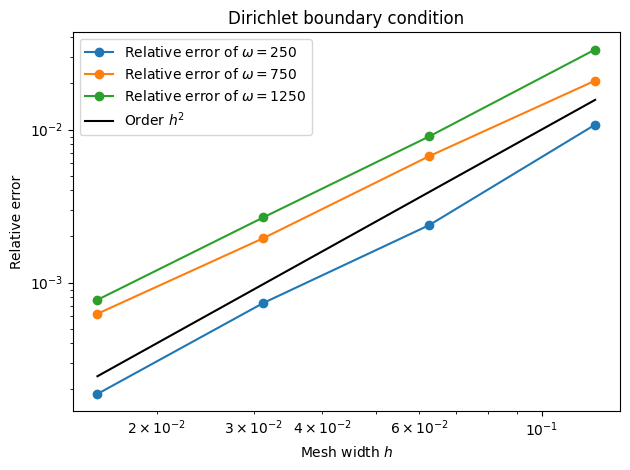

In [41]:
# Dirichlet problem
# L2 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    k = np.polyfit(np.log(hs), np.log(errors), 1)[0]
    print(f"convergence rate = {k:.2}")
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.92%
refinement level 1, relative error 1.30%
refinement level 2, relative error 0.64%
refinement level 3, relative error 0.32%
convergence rate = 1.1
----------------------------------------
angular freqency = 750
refinement level 0, relative error 6.98%
refinement level 1, relative error 3.39%
refinement level 2, relative error 1.67%
refinement level 3, relative error 0.83%
convergence rate = 1.0
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 11.61%
refinement level 1, relative error 5.66%
refinement level 2, relative error 2.81%
refinement level 3, relative error 1.40%
convergence rate = 1.0
----------------------------------------


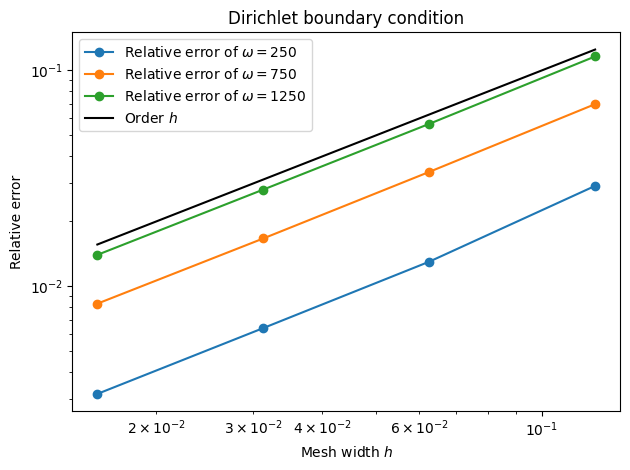

In [42]:
# Dirichlet problem
# H1 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, norm="h1", quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    k = np.polyfit(np.log(hs), np.log(errors), 1)[0]
    print(f"convergence rate = {k:.2}")
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.28%
refinement level 1, relative error 0.47%
refinement level 2, relative error 0.10%
refinement level 3, relative error 0.03%
convergence rate = 2.1
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.38%
refinement level 1, relative error 0.81%
refinement level 2, relative error 0.24%
refinement level 3, relative error 0.07%
convergence rate = 1.7
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.29%
refinement level 1, relative error 0.92%
refinement level 2, relative error 0.29%
refinement level 3, relative error 0.08%
convergence rate = 1.8
----------------------------------------


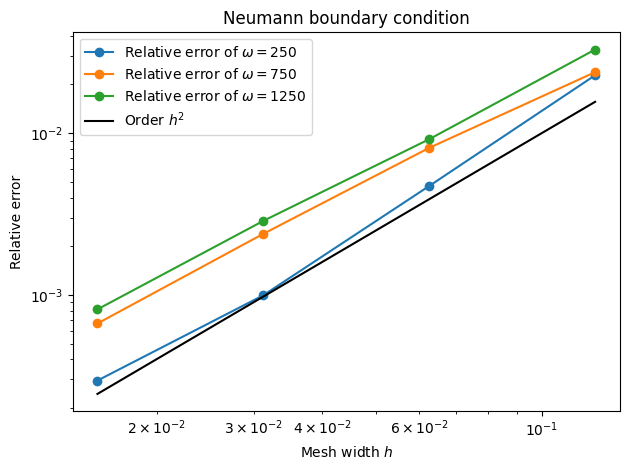

In [43]:
# Neumann problem
# L2 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    k = np.polyfit(np.log(hs), np.log(errors), 1)[0]
    print(f"convergence rate = {k:.2}")
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 3.21%
refinement level 1, relative error 1.33%
refinement level 2, relative error 0.64%
refinement level 3, relative error 0.32%
convergence rate = 1.1
----------------------------------------
angular freqency = 750
refinement level 0, relative error 7.13%
refinement level 1, relative error 3.43%
refinement level 2, relative error 1.67%
refinement level 3, relative error 0.83%
convergence rate = 1.0
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 11.63%
refinement level 1, relative error 5.66%
refinement level 2, relative error 2.81%
refinement level 3, relative error 1.40%
convergence rate = 1.0
----------------------------------------


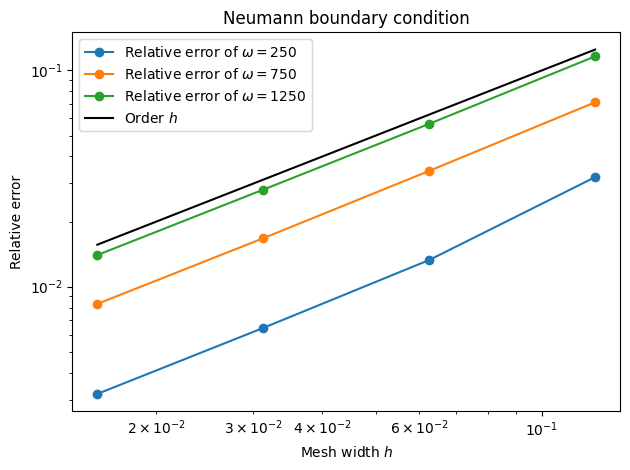

In [44]:
# Neumann problem
# H1 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, norm="h1", quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    k = np.polyfit(np.log(hs), np.log(errors), 1)[0]
    print(f"convergence rate = {k:.2}")
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

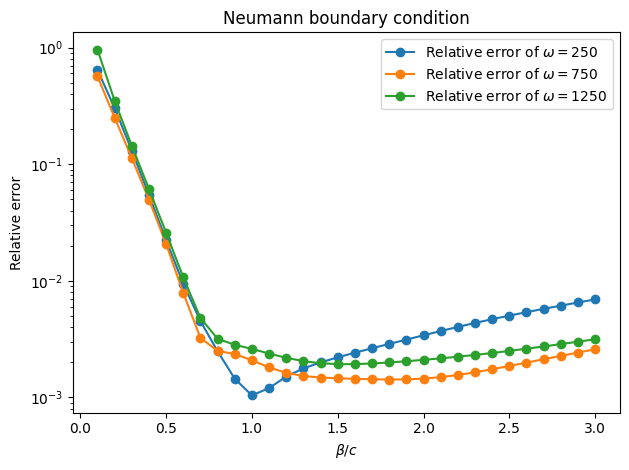

In [45]:
neumann = True
m = mesh_hierarchy[2]
betas = np.linspace(0.1, 3, 30)
for omega in omegas:
    # print(f"angular freqency = {omega}")
    k = omega / c
    g = neumann_bc(m, k, x0)
    u = exact_solution(m, k, x0)
    errors = []
    for beta in betas:
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, beta=beta)
        rel_err = compute_error(u, uh)
        # print(f"beta {beta:.2}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.semilogy(betas, errors, "-o",
             label=r"Relative error of $\omega=$"+f"{omega}")
    # print("----------------------------------------")

plt.legend()
plt.xlabel(r"$\beta / c$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()